# Centrality Measures - Part2
###### In this Part 2, 4 measures that are not in NetworkX are implemented.
###### The paper "Consistency and differences between centrality measures across distinct classes of networks"  describe these 4 measures as highly exclusive.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import statistics as st
from networkx.algorithms import community 

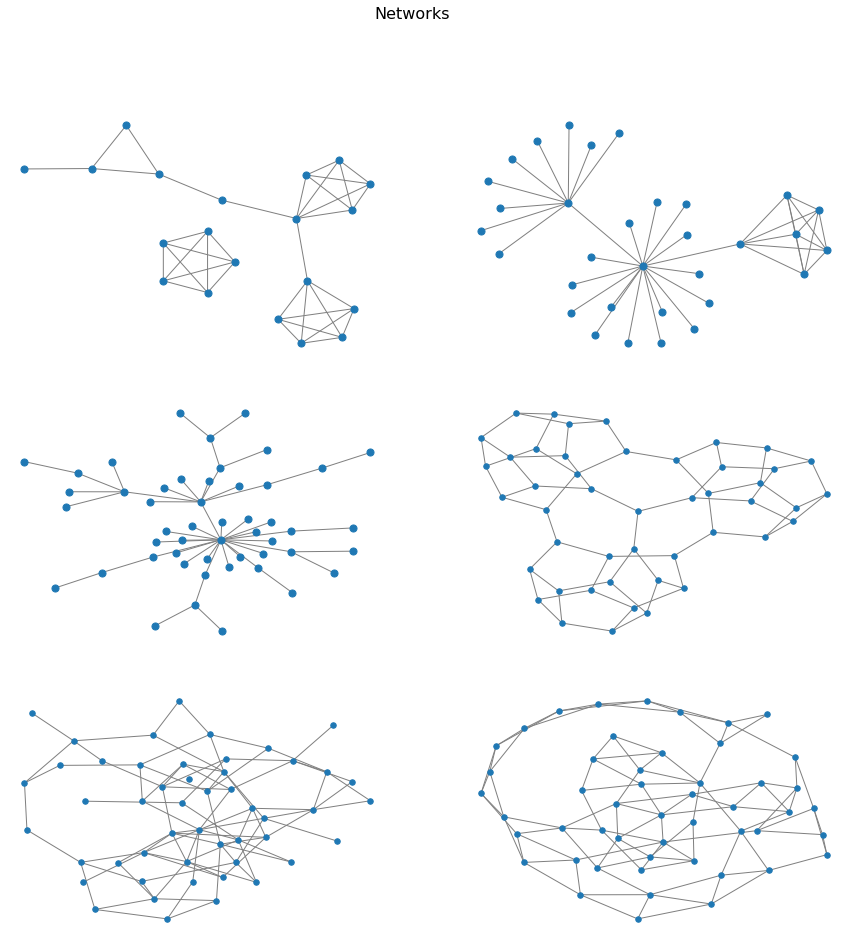

In [2]:
visualNetworks = {}
G = nx.lollipop_graph(5,5)
G = nx.disjoint_union(G, nx.complete_graph(range(10,15)))
G = nx.disjoint_union(G, nx.complete_graph(range(15,20)))
G.add_edges_from([(4,5),(6,8),(6,7),(4,19)])
visualNetworks["network1"] = G

G = nx.complete_graph(range(0,6))
nx.add_star(G, range(6,16))
nx.add_star(G, range(16,32))
G.add_edges_from([(16,6),(16,0)])
visualNetworks["network2"]=G
visualNetworks["network3"]=nx.barabasi_albert_graph(50,1)
visualNetworks["network4"] = nx.tutte_graph() 
visualNetworks["network5"]=nx.erdos_renyi_graph(50,0.08)
visualNetworks["network6"]=nx.watts_strogatz_graph(50,4,0.2)
fig, ax = plt.subplots(3,2,figsize=(15, 15))
fig.suptitle("Networks", fontsize=16)

plt.sca(ax[0,0])
ax[0,0] = nx.draw_kamada_kawai(visualNetworks["network1"],edge_color='gray',with_labels=0, node_size=50)
plt.sca(ax[0,1])
ax[0,1] = nx.draw_kamada_kawai(visualNetworks["network2"],edge_color='gray',with_labels=0, node_size=50)
plt.sca(ax[1,0])
ax[1,0] = nx.draw_kamada_kawai(visualNetworks["network3"],edge_color='gray',with_labels=0, node_size=50)
plt.sca(ax[1,1])
ax[1,1] = nx.draw_kamada_kawai(visualNetworks["network4"],edge_color='gray',with_labels=0, node_size=30)
plt.sca(ax[2,0])
ax[2,0] = nx.draw_kamada_kawai(visualNetworks["network5"],edge_color='gray',with_labels=0, node_size=30)
plt.sca(ax[2,1])
ax[2,1] = nx.draw_kamada_kawai(visualNetworks["network6"],edge_color='gray',with_labels=0, node_size=30)

plt.show()

In [3]:
def plotVisualMeasures(networks,mapping,name,description):
    plotLines=3
    plotCol=2
    fig, ax = plt.subplots(plotLines,plotCol,figsize=(15, 15))
    fig.suptitle(name+'\n'+description, fontsize=16)
    line=0
    col=0
    for rede in networks:
        #Some measures only works with 1 connect component (CC).Here we check de number of CC and get the Largest (LCC)
        if(len(networks[rede])!=len(mapping[rede])):
            redeAtual = networks[rede].subgraph(max(nx.connected_components(networks[rede]), key=len))
        else:
            redeAtual = networks[rede]

        measure = [round(mapping[rede][t],15) if mapping[rede][t]>0 else mapping[rede][t] for t in mapping[rede]]
                
        label ={}
        for k in mapping[rede].items():
            if k[1]!=0:
                label[k[0]]=round(k[1],2)
            else:
                label[k[0]]=k[1]

        vmin = min(measure)
        vmax = max(measure)
        cmap = plt.cm.Wistia
        plt.sca(ax[line,col])
        pos = nx.kamada_kawai_layout(redeAtual) 
        ax[line,col] = nx.draw(redeAtual,pos=pos, labels=label,edge_color='gray',with_labels=True, node_size=200,font_size=8,node_color=measure,cmap=cmap, vmin=vmin, vmax=vmax)

        col+=1
        if(col==plotCol):
            col=0
            line+=1
#     plt.tight_layout()
#     plt.savefig(name+'.png',dpi=140)
#     plt.close()
    plt.show()

# Manual implementation of 4 "new" measures 

In [4]:
#leverage centrality can assign negative values to a node, indicating that node has less connections than its neighbours. In this case, a node is said to be influenced by its neighbours.
def levarageCentrality(G):
    nodes = list(G.nodes)
    degrees = G.degree
    leverageCentrality ={}
    for node in nodes:
        if(len(list(G.neighbors(node)))==0):
            leverageCentrality[node] = 0
        else:
            leverage=0
            for n in G.neighbors(node):
                leverage += (degrees[node]-degrees[n]) / (degrees[node]+degrees[n])

            leverageCentrality[node] = round(((1/degrees[node]) * leverage),4)

    return leverageCentrality

def averageNeighborDegree(G):
    nodes = list(G.nodes)
    degrees = G.degree
    avgDegree = st.mean([t[1] for t in degrees])
    averageNeighborDegree ={}
    for node in nodes:
        neighborsDegree=0
        if(len(list(G.neighbors(node)))==0):
            averageNeighborDegree[node] = 0
        else:
            for n in G.neighbors(node):
                neighborsDegree += degrees[n]

            averageNeighborDegree[node] = neighborsDegree/len(list(G.neighbors(node)))

    return averageNeighborDegree

def bridgingCentrality(G):
    nodes = list(G.nodes)
    degrees = G.degree
    #betweenness
    bet = nx.betweenness_centrality(G)
    #bridging centrality
    bridging_centrality={}

    for node in nodes:
        if(degrees[node]!=0):
            nodeDegreeInverse = degrees[node]**-1
            neighborsDegreeInverse=0
            for n in G.neighbors(node):
                neighborsDegreeInverse += degrees[n]**-1

            bridging_centrality[node] = (nodeDegreeInverse/neighborsDegreeInverse) * bet[node]
        else:
            bridging_centrality[node] = 0
    return bridging_centrality


def pacticipantionCefficient(G):
# Ref: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0012200
# Ref2: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0220061

    pacticipantionCefficient={}
    communities = community.greedy_modularity_communities(G)
    numberOfModules = len(communities)
    for node in G.nodes:  
        neighbors = list(G.neighbors(node))
        #Avoid CC of size one
        if(len(neighbors)!=0):            
            pacticipantionCefficient[node]=0
            for com in communities:  
                neighborsInComunities=0
                for n in neighbors:
                    if n in com:
                        neighborsInComunities+=1
                if(neighborsInComunities>0):
                    pacticipantionCefficient[node]+=( (neighborsInComunities/len(neighbors) )**2)

            pacticipantionCefficient[node] = 1-pacticipantionCefficient[node] 
        else:
            pacticipantionCefficient[node] = 0
    return pacticipantionCefficient  

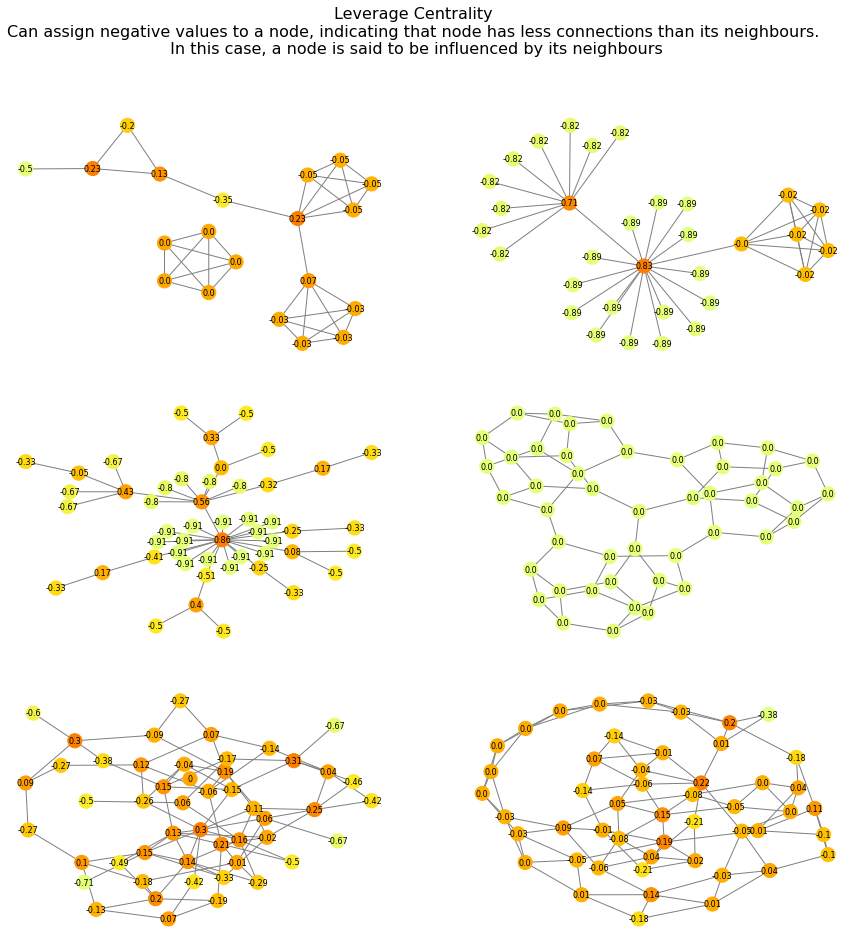

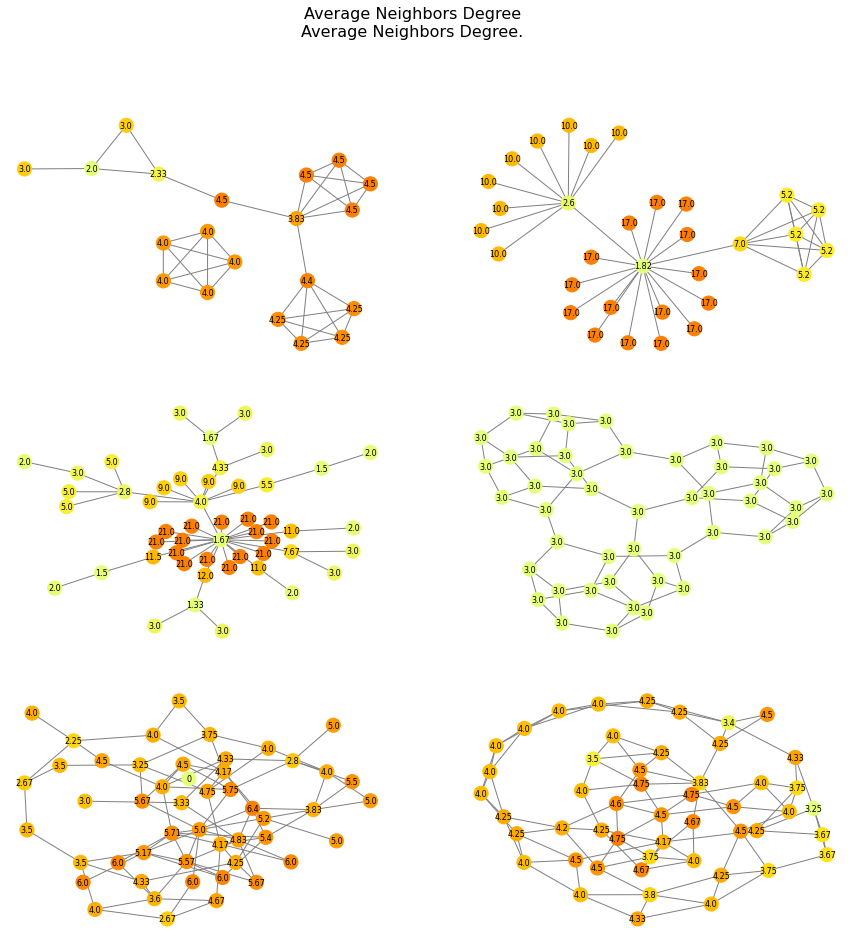

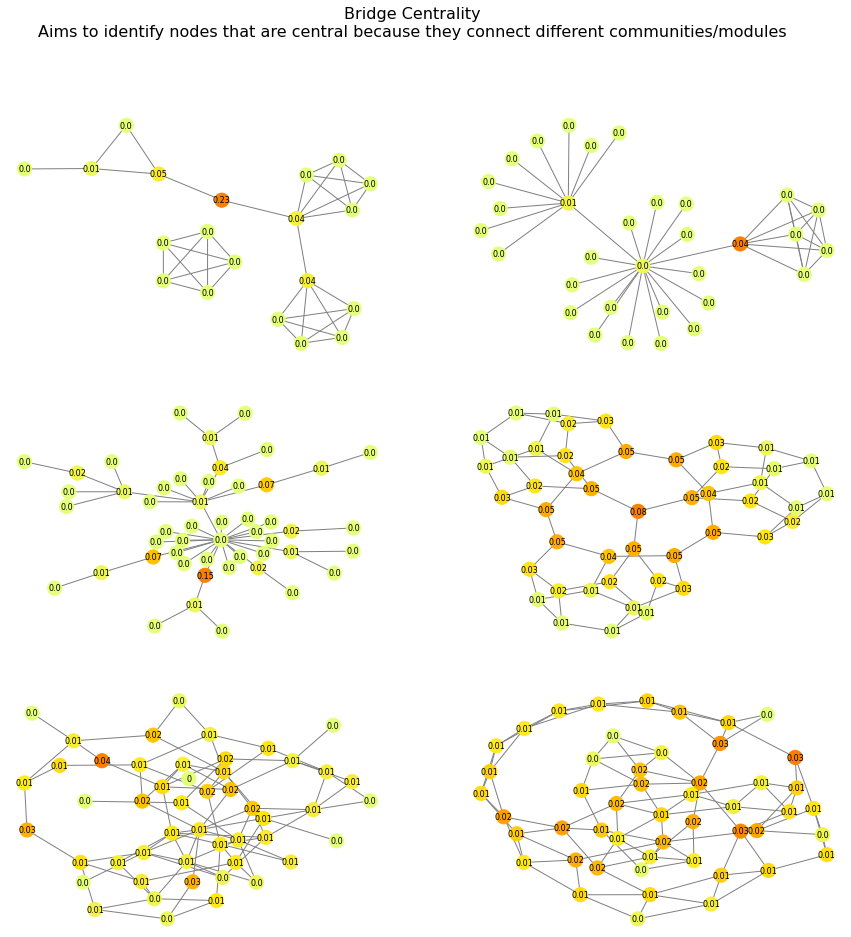

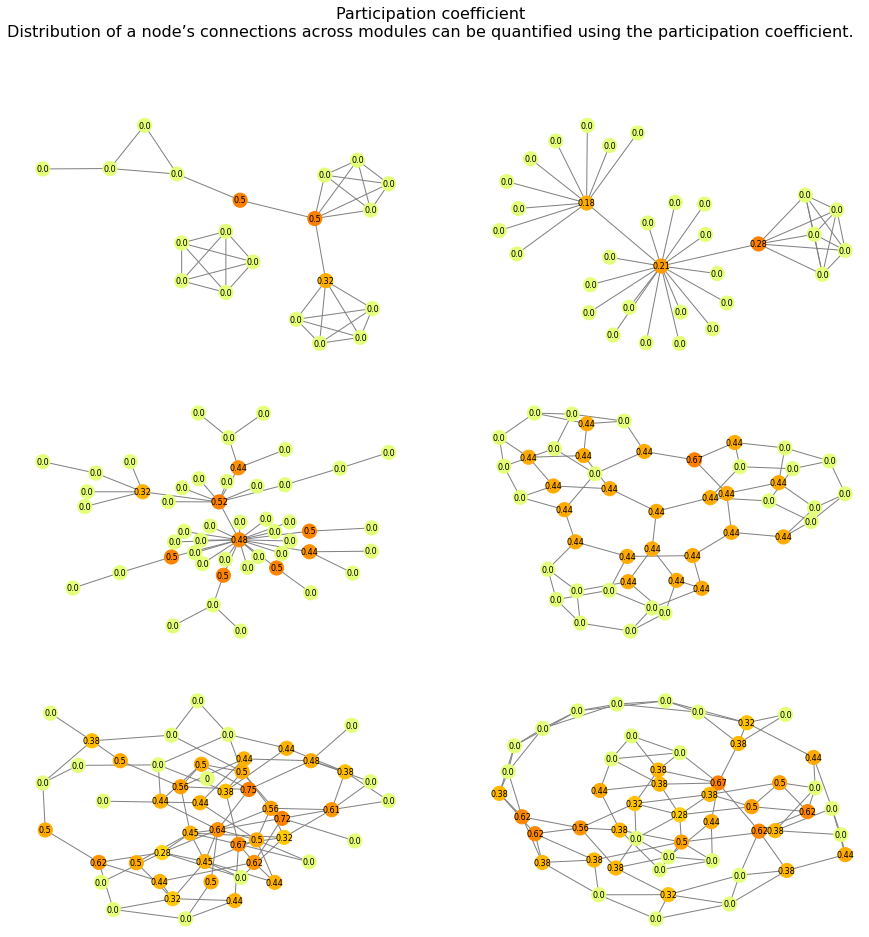

In [5]:
#leverage centrality
mapping={}
for net in visualNetworks:
    mapping[net] = levarageCentrality(visualNetworks[net])
plotVisualMeasures(visualNetworks,mapping,"Leverage Centrality","Can assign negative values to a node, indicating that node has less connections than its neighbours.\n In this case, a node is said to be influenced by its neighbours")

#Average Neighbors 
mapping={}
for net in visualNetworks:
    mapping[net] = averageNeighborDegree(visualNetworks[net])    
plotVisualMeasures(visualNetworks,mapping,"Average Neighbors Degree","Average Neighbors Degree.")   

#Bridge Centrality
mapping={}
for net in visualNetworks:
    mapping[net] = bridgingCentrality(visualNetworks[net])    
plotVisualMeasures(visualNetworks,mapping,"Bridge Centrality","Aims to identify nodes that are central because they connect different communities/modules")

#Participation coefficient
mapping={}
for net in visualNetworks:
    mapping[net] = pacticipantionCefficient(visualNetworks[net])    
plotVisualMeasures(visualNetworks,mapping,"Participation coefficient","Distribution of a node’s connections across modules can be quantified using the participation coefficient.")